In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spinmob as sm
import mcphysics as mphys
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2
%matplotlib inline

[1.2155816283349237, 1.120005097311341]
[1.1437728139194738, 1.1883081852626831]
[1.016432262629209, 1.217656693673426]
[33.77553168840128, 1.2666052409847919]
[1.1230635551360497, 1.120005097311341]
[  0.38585139 -19.8513708 ]


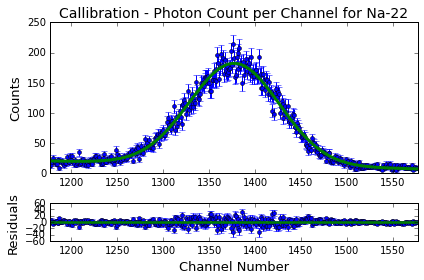

In [98]:
#Adds together 1 hour of calibration data for a given source
def Sum(source):
    yData = [0]*2048
    i=1
    j=0
    while i <= 12:
        while j < 10:
            yData += mphys.data.load_chn('Calibration/' + source + '/' + str(i) + '/' + source + '/' + source + 
                                         ' 00' + str(j) + '.Chn')[1]
            j += 1
        i += 1
    return yData

#Gaussian, where m=peak, o=standard deviation, A=amplitude, B=Linear Coeff., C=Linear Offset
def Gaussian(x, m, o, A, B, C):
    return A*np.exp(-0.5*(((x-m)/o)**2)) + B*x + C

#Function for linear curve-fit of peaks for each channel (i.e. for final callibration curve)
def Linear(x, a, b):
    return a*x+b

def ChiFit(fitparam, input_databox, interval, guess, error):
    index = np.arange(guess-interval, guess+interval)
    fit = Gaussian(index, *fitparam)
    out = ((input_databox[guess-interval: guess+interval]-fit)**2/(error[guess-interval: guess+interval])**2)
#    print(out)
    return np.sum(out[out < 10**3])/(interval*2 - 6 - (len(out)-len(out < 10**10)))

def modChiFit(fitparam, input_databox, interval, guess):
    index = np.arange(guess-interval, guess+interval)
    fit = Gaussian(index, *fitparam)
    out = ((input_databox[guess-interval: guess+interval]-fit)**2/(input_databox[guess-interval: guess+interval]))
    dof = interval*2 - 6 - (len(out)-len(out < 10**10))
    return [np.sum(out[out < 10**3])/(dof), chi2.ppf(0.95, df=dof)/dof]

def ChiLinear(fitparam, x, y):
    fit = Linear(x, *fitparam)
    return np.sum((y-fit)**2/y**2)

def invEnergy(E, A, B):
    return (1/A)*(E-B)

def ChiEnergy(fitparam, E, x, x_err):
    fit = invEnergy(E, *fitparam)
    return np.sum(((x-fit)**2)/x_err**2)

def Fit(input_databox, interval, guess):
    xData = np.arange(0, 2048)
    param, cov = curve_fit(Gaussian, xData[guess-interval:guess+interval], 
                           input_databox[guess-interval:guess+interval], p0=[guess, 10, 10, 10, 10])
    error = np.sqrt(np.diag(cov))
    print(modChiFit(param, input_databox, interval, int(param[0])))
    return [param, error, input_databox, interval]

Cs = Fit(Sum('Cs-137'), 200, 1762)
Ba_1 = Fit(Sum('Ba-133'), 85, 980)
Ba_2 = Fit(Sum('Ba-133'), 65, 830)
Co = Fit(Sum('Co-57'), 45, 375)
Na = Fit(Sum('Na-22'), 200, 1360)

yvalues = [662.1, 302.85, 356.0129,  511.0]
xvalues = [Cs[0][0], Ba_2[0][0], Ba_1[0][0],  Na[0][0]]
errvalues = [Cs[1][0], Ba_2[1][0], Ba_1[1][0],  Na[1][0]]

linearFit_par, linearFit_cov = curve_fit(Linear, xvalues, yvalues)

linearResid = np.asarray(yvalues) - Linear(np.asarray(xvalues), *linearFit_par)

def Plots(data, Name):
    xdata = np.arange(int(data[0][0])-data[3], int(data[0][0])+data[3])
    ydata = data[2][int(data[0][0])-data[3]:int(data[0][0])+data[3]]
    err = np.sqrt(ydata)
    residuals = Gaussian(xdata, *data[0])-ydata
    
    fig, ax = plt.subplots(2, 1, sharey='row', tight_layout = True, gridspec_kw={'height_ratios':[4,1]})
    ax[0].errorbar(xdata, ydata, yerr=err, zorder=-5, fmt='o', markersize='4')
    ax[0].plot(xdata, Gaussian(xdata, *data[0]), color='g', linewidth=3)
    ax[1].errorbar(xdata, residuals, yerr=err, zorder=-5, fmt='o', markersize='4')
    ax[1].plot(xdata, np.zeros(data[3]*2), color='g', linewidth=2.5)
    ax[0].set_xlim(int(data[0][0])-data[3], int(data[0][0])+data[3])
    ax[1].set_xlim(int(data[0][0])-data[3], int(data[0][0])+data[3])
    
    ax[1].set_xlabel('Channel Number', fontsize=13)
    ax[1].set_ylabel('Residuals', fontsize=13)
    ax[0].set_ylabel('Counts', fontsize=13)
    ax[0].set_title('Callibration - Photon Count per Channel for ' + str(Name), fontsize=14)
    
    fig.savefig('Plots/' + str(Name) + '_Callibration.png')

print(linearFit_par)
Plots(Na, 'Na-22')

[  0.38585139 -19.8513708 ]
[2.68506518e-03 3.46591808e+00]


(None, None)

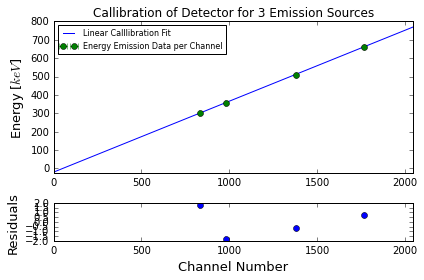

In [143]:
fig2, ax2 = plt.subplots(2, 1, sharey='row', tight_layout = True, gridspec_kw={'height_ratios':[4,1]})

ax2[0].plot(np.arange(0, 2048), Linear(np.arange(0, 2048), *linearFit_par), label='Linear Calllibration Fit')
ax2[0].errorbar(xvalues, yvalues, fmt='o', xerr=errvalues, label='Energy Emission Data per Channel')
ax2[0].set_xlim(0, 2048)
ax2[1].set_xlim(0, 2048)
ax2[0].set_ylim(bottom = -25)

ax2[1].errorbar(xvalues, linearResid, fmt='o', xerr=errvalues)
ax2[0].set_title('Callibration of Detector for 3 Emission Sources')

ax2[1].set_xlabel('Channel Number', fontsize=13)
ax2[1].set_ylabel('Residuals', fontsize=13)
ax2[0].set_ylabel('Energy [$keV$]', fontsize=13)
ax2[0].legend(loc='upper left', prop={'size':8})

fig2.savefig('Plots/LastOne.svg')

print(linearFit_par), print(np.sqrt(np.diag(linearFit_cov)))

In [326]:
Cs_error = np.sqrt(Sum('Cs-137'))
Ba_error = np.sqrt(Sum('Ba-133'))
Co_error = np.sqrt(Sum('Co-57'))
Na_error = np.sqrt(Sum('Na-22'))

def ChiFit(fitparam, input_databox, interval, guess, error):
    index = np.arange(guess-interval, guess+interval)
    fit = Gaussian(index, *fitparam)
    out = ((input_databox[guess-interval: guess+interval]-fit)**2/(error[guess-interval: guess+interval])**2)
#    print(out)
    return np.sum(out[out < 10**3])/(interval*2 - 6 - (len(out)-len(out < 10**10)))

print(ChiFit(Cs[0], Sum('Cs-137'), 147, int(Cs[0][0]), Cs_error))
print(ChiFit(Co[0], Sum('Co-57'), 18, int(Co[0][0]), Co_error))
print(ChiFit(Na[0], Sum('Na-22'), 50, int(Na[0][0]), Na_error))
print(117.632/(100-6))

testres = (Sum('Na-22')[int(Na[0][0]-50): int(Na[0][0])+50]-Gaussian(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), 
                                                                   *Na[0]))/Na_error[int(Na[0][0]-50): int(Na[0][0])+50]

#plt.scatter(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), Sum('Na-22')[int(Na[0][0]-50): int(Na[0][0])+50], zorder=-5)
#plt.plot(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), Gaussian(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), 
#                                                                   *Na[0]), linewidth=5)

#plt.errorbar(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), testres, yerr=Na_error[int(Na[0][0]-50): int(Na[0][0])+18])

#plt.scatter(np.arange(int(Cs[0][0])-147, int(Cs[0][0])+147), Sum('Cs-137')[int(Cs[0][0]-147): int(Cs[0][0])+147], zorder=-5)
#plt.plot(np.arange(int(Cs[0][0])-147, int(Cs[0][0])+147), Gaussian(np.arange(int(Cs[0][0])-147, int(Cs[0][0])+147), 
#                                                                   *Cs[0]), linewidth=5)

plt.scatter(np.arange(int(Co[0][0])-18, int(Co[0][0])+18), Sum('Co-57')[int(Co[0][0]-18): int(Co[0][0])+18])
plt.plot(np.arange(int(Co[0][0])-18, int(Co[0][0])+18), Gaussian(np.arange(int(Co[0][0])-18, int(Co[0][0])+18), *Co[0]))

#plt.scatter(np.arange(int(Co[0][0])-200, int(Co[0][0])+200), Sum('Co-57')[int(Co[0][0]-200): int(Co[0][0])+200])

#plt.scatter(np.arange(int(Ba[0][0])-50, int(Ba[0][0])+50), Sum('Ba-133')[int(Ba[0][0]-50): int(Ba[0][0])+50])
#plt.plot(np.arange(int(Ba[0][0])-50, int(Ba[0][0])+50), Gaussian(np.arange(int(Ba[0][0])-50, int(Ba[0][0])+50), *Ba[0]))

#plt.scatter(np.arange(0, 2048)[700: 1400], Sum('Ba-133')[700: 1400])

print(ChiFit(Ba_1[0], Sum('Ba-133'), 90, int(Ba_1[0][0]), Ba_error))

#plt.scatter(np.arange(int(Ba_1[0][0])-95, int(Ba_1[0][0])+95), Sum('Ba-133')[int(Ba_1[0][0]-95): int(Ba_1[0][0])+95])
#plt.plot(np.arange(int(Ba_1[0][0])-95, int(Ba_1[0][0])+95), Gaussian(np.arange(int(Ba_1[0][0])-95, int(Ba_1[0][0])+95), *Ba_1[0]))

print(ChiFit(Ba_2[0], Sum('Ba-133'), 25, int(Ba_2[0][0]), Ba_error))

#plt.scatter(np.arange(int(Ba_2[0][0])-25, int(Ba_2[0][0])+25), Sum('Ba-133')[int(Ba_2[0][0]-25): int(Ba_2[0][0])+25])
#plt.plot(np.arange(int(Ba_2[0][0])-25, int(Ba_2[0][0])+25), Gaussian(np.arange(int(Ba_2[0][0])-25, int(Ba_2[0][0])+25), *Ba_2[0]))

#print(ChiFit(Cs[0], Sum('Cs-137'), 100, int(Cs[0][0]), Cs_error))
#print(227.496/(200-6))

print(Co[0])

[ 1.37756748e+03 -4.91462423e+01  1.68373660e+02 -3.27671981e-02
  5.89248393e+01]
[4.18387181e-01 4.94759713e-01 1.25756572e+00 4.19109977e-03
 5.60601051e+00]


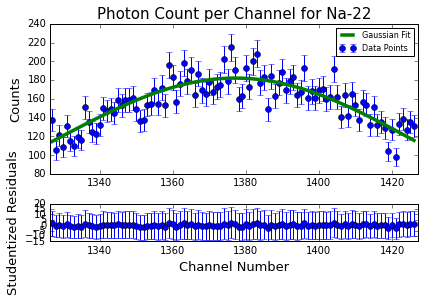

In [419]:
sodiumRes = (Sum('Na-22')[int(Na[0][0]-50): int(Na[0][0])+50]-Gaussian(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), 
                                                                   *Na[0]))/Na_error[int(Na[0][0]-50): int(Na[0][0])+50]

fig, ax = plt.subplots(2, 1, sharey='row', tight_layout = True, gridspec_kw={'height_ratios':[4,1]})

ax[0].errorbar(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), Sum('Na-22')[int(Na[0][0]-50): int(Na[0][0])+50], 
               zorder=-5, fmt='o', yerr=Na_error[int(Na[0][0]-50): int(Na[0][0])+50], label='Data Points')
ax[0].plot(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), Gaussian(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), 
                                                                   *Na[0]), linewidth=3.5, label='Gaussian Fit')
ax[1].errorbar(np.arange(int(Na[0][0])-50, int(Na[0][0])+50), sodiumRes, 
               yerr=Na_error[int(Na[0][0]-50): int(Na[0][0])+50], fmt='o')

ax[0].set_xlim(int(Na[0][0])-50.5, int(Na[0][0])+50)
ax[1].set_xlim(int(Na[0][0])-50.5, int(Na[0][0])+50)

ax[1].set_xlabel('Channel Number', fontsize=13)
ax[1].set_ylabel('Studentized Residuals', fontsize=13)
ax[0].set_ylabel('Counts', fontsize=13)
ax[0].legend(loc='upper right', prop={'size':8})
ax[0].set_title('Photon Count per Channel for Na-22', fontsize=15)

fig.savefig('Plots/Na.svg')

print(Na[0])
print(Na[1])

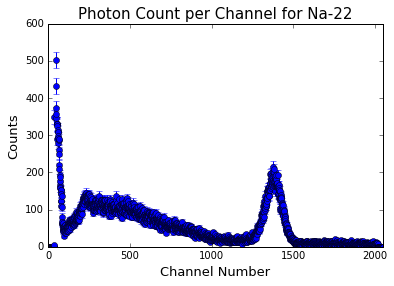

In [418]:
plt.errorbar(np.arange(0, 2048), Sum('Na-22'), 
               zorder=-5, fmt='o', yerr=Na_error)
plt.ylim(top = 600)
plt.xlim(-0, right = 2047)
plt.title('Photon Count per Channel for Na-22', fontsize=15)
plt.xlabel('Channel Number', fontsize=13)
plt.ylabel('Counts', fontsize=13)

plt.savefig('Plots/bigFig.svg')

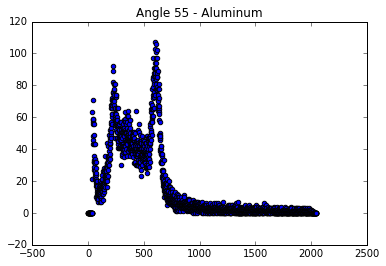

[ 6.06927659e+02 -2.97122177e+01  6.65845702e+01 -1.23367441e-01
  9.91510461e+01]
[0.70946741 0.88648407 1.39445486 0.00999281 6.13671795]


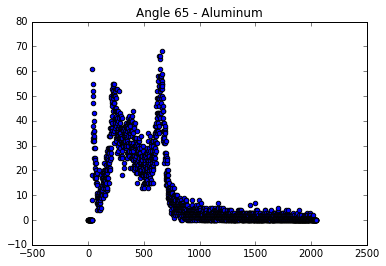

[ 6.50073872e+02  3.08226760e+01  3.81686893e+01 -7.98757323e-02
  6.74700352e+01]
[1.11773496 1.45912189 1.25663806 0.00970231 5.81142685]


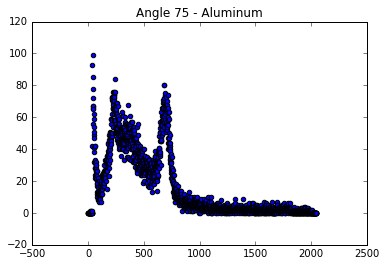

[ 6.92194465e+02  3.66772352e+01  4.97658116e+01 -8.45180409e-02
  7.57944455e+01]
[1.07751106 1.5231135  1.40939228 0.01020258 7.14576929]


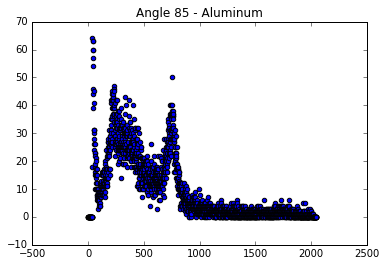

[ 7.48553350e+02  3.34601728e+01  2.26718405e+01 -3.14688702e-02
  3.43000785e+01]
[1.51949811 2.02296613 0.93349726 0.00690378 5.1145174 ]


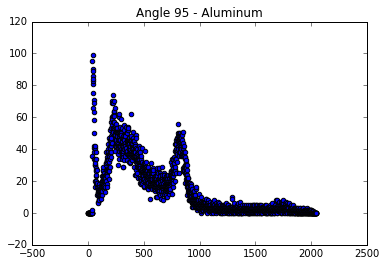

[ 8.24382563e+02  4.29128886e+01  3.25920864e+01 -3.56455158e-02
  4.16460850e+01]
[1.89158562 3.01549662 1.74153001 0.01103542 9.84553125]


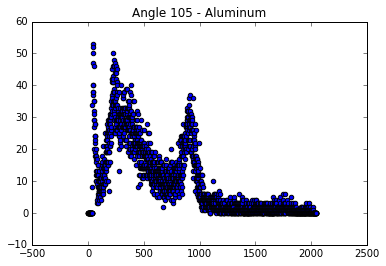

[ 9.01771524e+02  5.34168265e+01  2.39640900e+01  4.91402239e-03
 -8.19073399e-01]
[6.44331533e+00 9.09570705e+00 5.42011691e+00 3.21191714e-02
 3.42997542e+01]


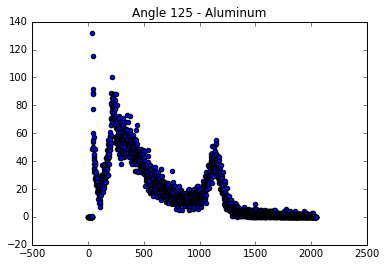

[ 1.13923359e+03  5.37777235e+01  3.03660799e+01 -2.97253540e-02
  4.39778046e+01]
[3.39486243e+00 6.53672319e+00 3.69046731e+00 1.62483309e-02
 1.71180008e+01]


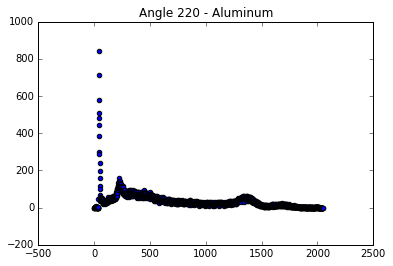

[ 1.36488035e+03  7.04794845e+01  4.51939853e+01 -6.44347676e-02
  9.49955413e+01]
[7.42059108e+00 1.51303780e+01 1.35338991e+01 4.44667405e-02
 5.03308572e+01]


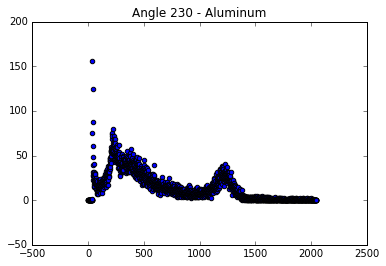

[ 1.22279876e+03  5.31755731e+01  1.99808206e+01 -1.29051448e-02
  2.49777337e+01]
[4.52051687e+00 8.91191265e+00 3.22279856e+00 1.37816165e-02
 1.73793650e+01]


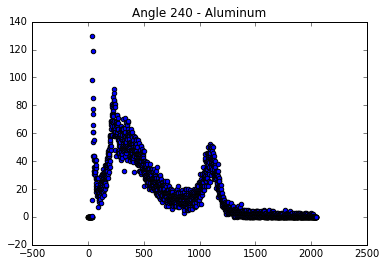

[ 1.10249748e+03  5.48030443e+01  3.07530052e+01 -2.27554843e-02
  3.49137368e+01]
[3.69666618e+00 7.29626451e+00 4.16596813e+00 1.75233435e-02
 2.15239093e+01]


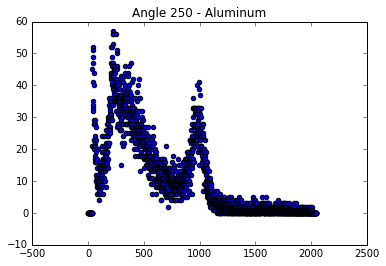

[ 9.82932980e+02  4.89170657e+01  2.13857082e+01 -2.29191449e-02
  2.96495008e+01]
[3.42680323e+00 6.14558580e+00 2.36139042e+00 1.20813752e-02
 1.28913809e+01]


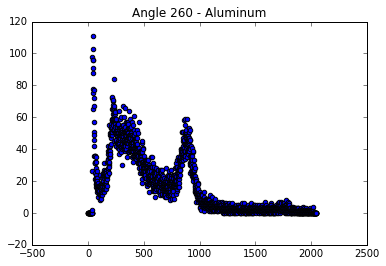

[ 8.82823814e+02  5.10455583e+01  3.61510201e+01 -3.30531818e-02
  3.90370756e+01]
[ 2.61790434  4.89330114  3.20553468  0.01513278 12.77907989]


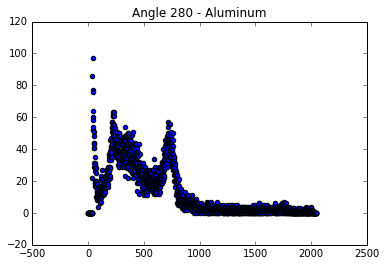

[ 7.31360097e+02  4.00210245e+01  3.26534972e+01 -6.24594792e-02
  5.79664723e+01]
[1.67978836 2.53517216 1.47520318 0.01009129 7.19525705]


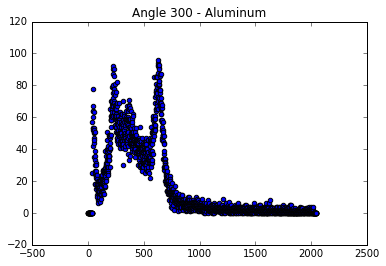

[ 6.31559648e+02 -3.26966783e+01  5.79853814e+01 -1.08924661e-01
  9.30031835e+01]
[0.89236188 1.17100315 1.41862268 0.01043864 6.64502022]


In [76]:
#Gaussian, where m=peak, o=variance, A=amplitude, B=Linear Coeff., C=Linear Offset
def Gaussian(x, m, o, A, B, C):
    return A*np.exp(-0.5*(((x-m)/o)**2)) + B*x + C

#Curve fits a Gaussian to a given emitter's callibration data curve. The interval determines the width of data
#which the Gaussian fits around. 
def Fit(input_databox, interval, guess):
    xData = np.arange(0, 2048)
    param, cov = curve_fit(Gaussian, xData[guess-interval:guess+interval], 
                           input_databox[guess-interval:guess+interval], p0=[guess, 10, 10, 10, 10])
    error = np.sqrt(np.diag(cov))
    print(param), print(error)
    return [param, error]

def Chi(fitparam, input_databox, interval, guess):
    index = np.arange(int(fitparam[0])-interval, int(fitparam[0])+interval)
    fit = Gaussian(index, *fitparam)
    out = ((input_databox[int(fitparam[0])-interval: int(fitparam[0])+interval]-fit)**2/(
        input_databox[int(fitparam[0])-interval: int(fitparam[0])+interval]))
    dof = interval*2 - 6 - (len(out)-len(out < 10**10))
    return [np.sum(out[out < 10**3])/(dof), chi2.ppf(0.95, df=dof)/dof]

##### ALUMINUM
### Al 55
data1 = mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 000.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 024.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 006.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 010.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 014.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 020.Chn')[1]
data1 += mphys.data.load_chn('Compton/Angles/55/02 Aluminum/02 Aluminum 55 degrees 033.Chn')[1]

plt.scatter(np.arange(0, 2048), data1)
plt.title('Angle 55 - Aluminum')
plt.show()

Al_55peak_x = 607
Al_55param = Fit(data1, 100, Al_55peak_x)
Al_55chi = Chi(Al_55param[0], data1, 100, Al_55peak_x)

### Al 65
data2 = mphys.data.load_chn('Compton/Angles/65/02 Aluminum/02 Aluminum 65 degrees 009.Chn')[1]
data2 += mphys.data.load_chn('Compton/Angles/65/02 Aluminum/02 Aluminum 65 degrees 017.Chn')[1]
data2 += mphys.data.load_chn('Compton/Angles/65/02 Aluminum/02 Aluminum 65 degrees 023.Chn')[1]
data2 += mphys.data.load_chn('Compton/Angles/65/02 Aluminum/02 Aluminum 65 degrees 030.Chn')[1]
data2 += mphys.data.load_chn('Compton/Angles/65/02 Aluminum/02 Aluminum 65 degrees 037.Chn')[1]

plt.scatter(np.arange(0, 2048), data2)
plt.title('Angle 65 - Aluminum')
plt.show()

Al_65peak_x = 637
Al_65param = Fit(data2, 100, Al_65peak_x)
Al_65chi = Chi(Al_65param[0], data2, 100, Al_65peak_x)

### Al 75
data3 = mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 024.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 030.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 008.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 012.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 021.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 028.Chn')[1]
data3 += mphys.data.load_chn('Compton/Angles/75/02 Aluminum/02 Aluminum 75 degrees 036.Chn')[1]

plt.scatter(np.arange(0, 2048), data3)
plt.title('Angle 75 - Aluminum')
plt.show()

Al_75peak_x = 692
Al_75param = Fit(data3, 100, Al_75peak_x)
Al_75chi = Chi(Al_75param[0], data3, 100, Al_75peak_x)

### Al 85
data4 = mphys.data.load_chn('Compton/Angles/85/02 Aluminum/02 Aluminum 85 degrees 000.Chn')[1]
data4 += mphys.data.load_chn('Compton/Angles/85/02 Aluminum/02 Aluminum 85 degrees 007.Chn')[1]
data4 += mphys.data.load_chn('Compton/Angles/85/02 Aluminum/02 Aluminum 85 degrees 018.Chn')[1]
data4 += mphys.data.load_chn('Compton/Angles/85/02 Aluminum/02 Aluminum 85 degrees 035.Chn')[1]


plt.scatter(np.arange(0, 2048), data4)
plt.title('Angle 85 - Aluminum')
plt.show()

Al_85peak_x = 746
Al_85param = Fit(data4, 100, Al_85peak_x)
Al_85chi = Chi(Al_85param[0], data4, 100, Al_85peak_x)

### Al 95
data5 = mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 002.Chn')[1]
data5 += mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 028.Chn')[1]
data5 += mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 007.Chn')[1]
data5 += mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 023.Chn')[1]
data5 += mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 025.Chn')[1]
data5 += mphys.data.load_chn('Compton/Angles/95/02 Aluminum/02 Aluminum 95 degrees 037.Chn')[1]

plt.scatter(np.arange(0, 2048), data5)
plt.title('Angle 95 - Aluminum')
plt.show()

Al_95peak_x = 830
Al_95param = Fit(data5, 100, Al_95peak_x)
Al_95chi = Chi(Al_95param[0], data5, 100, Al_95peak_x)

### Al 105
data6 = mphys.data.load_chn('Compton/Angles/105/02 Aluminum/02 Aluminum 105 degrees 003.Chn')[1]
data6 += mphys.data.load_chn('Compton/Angles/105/02 Aluminum/02 Aluminum 105 degrees 023.Chn')[1]
data6 += mphys.data.load_chn('Compton/Angles/105/02 Aluminum/02 Aluminum 105 degrees 028.Chn')[1]
data6 += mphys.data.load_chn('Compton/Angles/105/02 Aluminum/02 Aluminum 105 degrees 038.Chn')[1]

plt.scatter(np.arange(0, 2048), data6)
plt.title('Angle 105 - Aluminum')
plt.show()

Al_105peak_x = 930
Al_105param = Fit(data6, 100, Al_105peak_x)
Al_105chi = Chi(Al_105param[0], data6, 100, Al_105peak_x)

### Al 125
data7 = mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 027.Chn')[1]
data7 += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 036.Chn')[1]
data7 += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 016.Chn')[1]
data7 += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 024.Chn')[1]
data7 += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 030.Chn')[1]
data7 += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 032.Chn')[1]

plt.scatter(np.arange(0, 2048), data7)
plt.title('Angle 125 - Aluminum')
plt.show()

Al_125peak_x = 1133
Al_125param = Fit(data7, 100, Al_125peak_x)
Al_125chi = Chi(Al_125param[0], data7, 100, Al_125peak_x)

### Al 220
data8 = mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 036.Chn')[1]
data8 += mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 039.Chn')[1]
data8 += mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 021.Chn')[1]
data8 += mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 023.Chn')[1]
data8 += mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 031.Chn')[1]
data8 += mphys.data.load_chn('Compton/Angles/220/02 Aluminum/02 Aluminum 220 degrees 033.Chn')[1]

plt.scatter(np.arange(0, 2048), data8)
plt.title('Angle 220 - Aluminum')
plt.show()

Al_220peak_x = 1350
Al_220param = Fit(data8, 100, Al_220peak_x)
Al_220chi = Chi(Al_220param[0], data8, 100, Al_220peak_x)

### Al 230
data9 = mphys.data.load_chn('Compton/Angles/230/02 Aluminum/02 Aluminum 230 degrees 005.Chn')[1]
data9 += mphys.data.load_chn('Compton/Angles/230/02 Aluminum/02 Aluminum 230 degrees 009.Chn')[1]
data9 += mphys.data.load_chn('Compton/Angles/230/02 Aluminum/02 Aluminum 230 degrees 018.Chn')[1]
data9 += mphys.data.load_chn('Compton/Angles/230/02 Aluminum/02 Aluminum 230 degrees 024.Chn')[1]

plt.scatter(np.arange(0, 2048), data9)
plt.title('Angle 230 - Aluminum')
plt.show()

Al_230peak_x = 1224
Al_230param = Fit(data9, 100, Al_230peak_x)
Al_230chi = Chi(Al_230param[0], data9, 100, Al_230peak_x)

### Al 240
data10 = mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 002.Chn')[1]
data10 += mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 007.Chn')[1]
data10 += mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 015.Chn')[1]
data10 += mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 021.Chn')[1]
data10 += mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 025.Chn')[1]
data10 += mphys.data.load_chn('Compton/Angles/240/02 Aluminum/02 Aluminum 240 degrees 032.Chn')[1]

plt.scatter(np.arange(0, 2048), data10)
plt.title('Angle 240 - Aluminum')
plt.show()

Al_240peak_x = 1109
Al_240param = Fit(data10, 100, Al_240peak_x)
Al_240chi = Chi(Al_240param[0], data10, 100, Al_240peak_x)

### Al 250
data11 = mphys.data.load_chn('Compton/Angles/250/02 Aluminum/02 Aluminum 250 degrees 015.Chn')[1]
data11 += mphys.data.load_chn('Compton/Angles/250/02 Aluminum/02 Aluminum 250 degrees 016.Chn')[1]
data11 += mphys.data.load_chn('Compton/Angles/250/02 Aluminum/02 Aluminum 250 degrees 019.Chn')[1]
data11 += mphys.data.load_chn('Compton/Angles/250/02 Aluminum/02 Aluminum 250 degrees 021.Chn')[1]

plt.scatter(np.arange(0, 2048), data11)
plt.title('Angle 250 - Aluminum')
plt.show()

Al_250peak_x = 988
Al_250param = Fit(data11, 100, Al_250peak_x)
Al_250chi = Chi(Al_250param[0], data11, 100, Al_250peak_x)

### Al 260
data12 = mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 006.Chn')[1]
data12 += mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 039.Chn')[1]
data12 += mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 000.Chn')[1]
data12 += mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 012.Chn')[1]
data12 += mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 013.Chn')[1]
data12 += mphys.data.load_chn('Compton/Angles/260/02 Aluminum/02 Aluminum 260 degrees 029.Chn')[1]

plt.scatter(np.arange(0, 2048), data12)
plt.title('Angle 260 - Aluminum')
plt.show()

Al_260peak_x = 879
Al_260param = Fit(data12, 100, Al_260peak_x)
Al_260chi = Chi(Al_260param[0], data12, 100, Al_260peak_x)

### Al 280
data13 = mphys.data.load_chn('Compton/Angles/280/02 Aluminum/02 Aluminum 280 degrees 003.Chn')[1]
data13 += mphys.data.load_chn('Compton/Angles/280/02 Aluminum/02 Aluminum 280 degrees 007.Chn')[1]
data13 += mphys.data.load_chn('Compton/Angles/280/02 Aluminum/02 Aluminum 280 degrees 020.Chn')[1]
data13 += mphys.data.load_chn('Compton/Angles/280/02 Aluminum/02 Aluminum 280 degrees 027.Chn')[1]
data13 += mphys.data.load_chn('Compton/Angles/280/02 Aluminum/02 Aluminum 280 degrees 031.Chn')[1]

plt.scatter(np.arange(0, 2048), data13)
plt.title('Angle 280 - Aluminum')
plt.show()

Al_280peak_x = 728
Al_280param = Fit(data13, 100, Al_280peak_x)
Al_280chi = Chi(Al_280param[0], data13, 100, Al_280peak_x)

### Al 300
data14 = mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 002.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 013.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 017.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 026.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 027.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 032.Chn')[1]
data14 += mphys.data.load_chn('Compton/Angles/300/02 Aluminum/02 Aluminum 300 degrees 033.Chn')[1]

plt.scatter(np.arange(0, 2048), data14)
plt.title('Angle 300 - Aluminum')
plt.show()

Al_300peak_x = 631
Al_300param = Fit(data14, 100, Al_300peak_x)
Al_300chi = Chi(Al_300param[0], data14, 100, Al_300peak_x)

peaks = np.asarray([Al_55param[0][0], Al_65param[0][0], Al_75param[0][0], Al_85param[0][0], Al_95param[0][0], 
                  Al_105param[0][0], Al_125param[0][0], Al_220param[0][0], Al_230param[0][0], Al_240param[0][0], 
                  Al_250param[0][0], Al_260param[0][0], Al_280param[0][0], Al_300param[0][0]])

err = np.asarray([Al_55param[1][0], Al_65param[1][0], Al_75param[1][0], Al_85param[1][0], Al_95param[1][0], 
                  Al_105param[1][0], Al_125param[1][0], Al_220param[1][0], Al_230param[1][0], Al_240param[1][0], 
                  Al_250param[1][0], Al_260param[1][0], Al_280param[1][0], Al_300param[1][0]])

In [99]:
Al_chis = [Al_55chi, Al_65chi, Al_75chi, Al_85chi, Al_95chi, Al_105chi, Al_125chi, Al_220chi, Al_230chi, Al_240chi, 
                  Al_250chi, Al_260chi, Al_280chi, Al_300chi]

for i in np.arange(0, len(Al_chis)):
    print(Al_chis[i])
    

[0.9831143198787865, 1.1726620371546508]
[1.139404933679215, 1.1726620371546508]
[1.0306134727586542, 1.1726620371546508]
[1.1296132921902868, 1.1726620371546508]
[1.1135515621499084, 1.1726620371546508]
[1.4774527893228324, 1.1726620371546508]
[1.0300148968873373, 1.1726620371546508]
[1.0768137628286123, 1.1726620371546508]
[1.3153225316068091, 1.1726620371546508]
[1.1412994637137095, 1.1726620371546508]
[1.5676443222583594, 1.1726620371546508]
[1.0467095570260467, 1.1726620371546508]
[1.2415435115049418, 1.1726620371546508]
[1.0141478340582613, 1.1726620371546508]


[-125 -115 -105  -95  -85  -75  -55   40   50   60   70   80  100  120]
[214.33251099 230.98053719 247.23282676 268.97898084 298.23778826
 328.09842651 419.72349542 506.7896105  451.96723301 405.54881733
 359.41468715 320.7874262  262.34494032 223.83679825]
[502.11405767   0.82878912]
[1.78862287 0.14992396]
42.34269380160672


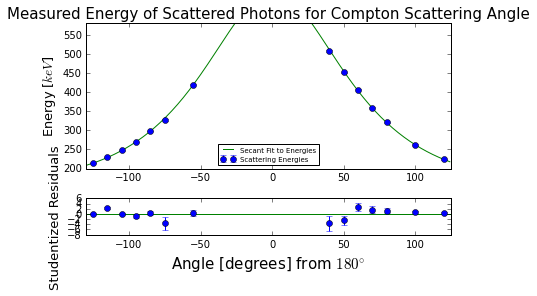

In [155]:
from scipy import constants

def Chi2(angles, param, data, err):
    return np.sum((data-Energy(angles, *param))**2/(err)**2)

def Energy(angles, m, phi):
    return 1/((1/661.657)+(1/m)*(1-np.cos(np.deg2rad(np.abs(angles-phi)))))

angles = np.asarray([55, 65, 75, 85, 95, 105, 125, 220, 230, 240, 250, 260, 280, 300])-180

energies = Linear(peaks, *linearFit_par)

energies_err = linearFit_par[0]*np.asarray(err)

test1, test2 = curve_fit(Energy, angles, energies, p0=[510, 0.1])

energyResid = (energies-Energy(angles, *test1))

print(angles)
print(energies)

plt1, ax1 = plt.subplots(2, 1, sharey='row', tight_layout = True, gridspec_kw={'height_ratios':[4,1]})

ax1[0].errorbar(angles, energies, yerr=energies_err, fmt='o', label='Scattering Energies')
ax1[0].plot(np.arange(-130, 125), Energy(np.arange(-130, 125), *test1), label = 'Secant Fit to Energies')
ax1[0].set_ylim(top = 580)

ax1[0].set_xlim(-130, 125)
ax1[1].set_xlim(-130, 125)

ax1[1].errorbar(angles, energyResid, yerr=energies_err, fmt='o')
ax1[1].plot(np.arange(-130, 125), np.zeros(130+125))

ax1[1].set_xlabel('Angle [degrees] from $180^{\circ}$', fontsize=15)
ax1[1].set_ylabel('Studentized Residuals', fontsize=13)
ax1[0].set_ylabel('Energy [$keV$]', fontsize=13)
ax1[0].legend(loc='lower center', prop={'size':7})
ax1[0].set_title('Measured Energy of Scattered Photons for Compton Scattering Angle', fontsize=15)

plt1.savefig('Plots/Energy_Plot.svg')

print(test1), print(np.sqrt(np.diag(test2)))
print(Chi2(angles, test1, energies, energies_err))

## P values - Cross Section

[183.8838061  163.29700595]
[ 1.81494690e+02  1.25920874e+02 -1.25094646e-01]


(None, None)

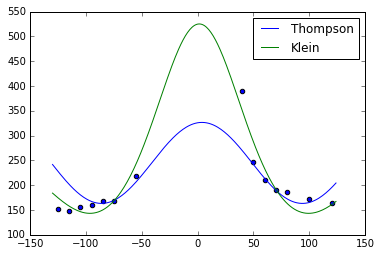

In [165]:
def Thompson(theta, phi, A):
    return A*(1+np.cos(np.deg2rad(theta - phi))**2)

tot_counts = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14]
p_den = [3.5, 2.5, 3.5, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2.5, 3.5]
total = np.zeros(len(tot_counts))

for i in np.arange(0, len(tot_counts)):
    total[i] += np.sum(tot_counts[i])

pval = np.asarray(total)/(np.asarray(p_den)*60)

#pval = np.abs(np.asarray([Al_55param[0][1], Al_65param[0][1], Al_75param[0][1], Al_85param[0][1], Al_95param[0][1], 
#                  Al_105param[0][1], Al_125param[0][1], Al_220param[0][1], Al_230param[0][1], Al_240param[0][1], 
#                  Al_250param[0][1], Al_260param[0][1], Al_280param[0][1], Al_300param[0][1]]))

#pval = pval/(60*np.asarray(p_den))

##Thompson
tparam, tcov = curve_fit(Thompson, angles, pval, p0=[0.1, 3])

plt.scatter(angles, pval)
plt.plot(np.arange(-130, 125), Thompson(np.arange(-130, 125), *tparam), label='Thompson')

##Klein
def Klein(theta, phi, A, a):
    cos = np.cos(np.deg2rad(theta - phi))
    one = (1+cos**2)/(1+a*(1-cos)**2)
    two = a**2*(1-cos)**2
    three = (1+cos**2)*(1+a*(1-cos))
    four = 1+(two/three)
    return A*one*four

kparam, kcov = curve_fit(Klein, angles, pval, p0=[0.1, 3, 2])

plt.plot(np.arange(-130, 125), Klein(np.arange(-130, 125), *kparam), label='Klein')
plt.legend()
print(tparam), print(kparam)

[184.21812607 164.51969863]
[362.75864257 201.11744153   0.43728186]


(None, None)

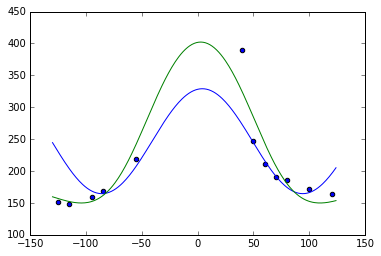

In [132]:
angles = np.asarray([55, 65, 85, 95, 125, 220, 230, 240, 250, 260, 280, 300])-180

def Thompson(theta, phi, A):
    return A*(1+np.cos(np.deg2rad(theta - phi))**2)

tot_counts = [data1, data2, data4, data5, data7, data8, data9, data10, data11, data12, data13, data14]
p_den = [3.5, 2.5, 2, 3, 3, 3, 2, 3, 2, 3, 2.5, 3.5]
total = np.zeros(len(tot_counts))

for i in np.arange(0, len(tot_counts)):
    total[i] += np.sum(tot_counts[i])

pval = np.asarray(total)/(np.asarray(p_den)*60)

#pval = np.asarray([Al_55param[0][1], Al_65param[0][1], Al_75param[0][1], Al_85param[0][1], Al_95param[0][1], 
#                  Al_105param[0][1], Al_125param[0][1], Al_220param[0][1], Al_230param[0][1], Al_240param[0][1], 
#                  Al_250param[0][1], Al_260param[0][1], Al_280param[0][1], Al_300param[0][1]])

#pval = pval/(60*np.asarray(p_den))

##Thompson
tparam, tcov = curve_fit(Thompson, angles, pval, p0=[0.1, 3])

plt.scatter(angles, pval)
plt.plot(np.arange(-130, 125), Thompson(np.arange(-130, 125), *tparam))

##Klein
def Klein(theta, phi, A, a):
    cos = np.cos(np.deg2rad(theta - phi))
    one = (1+cos**2)/(1+a*(1-cos)**2)
    two = a**2*(1-cos)**2
    three = (1+cos**2)*(1+a*(1-cos))
    four = 1+(two/three)
    return A*one*four

kparam, kcov = curve_fit(Klein, angles, pval, p0=[0.1, 3, 2])

plt.plot(np.arange(-130, 125), Klein(np.arange(-130, 125), *kparam))
print(tparam), print(kparam)

## Copper

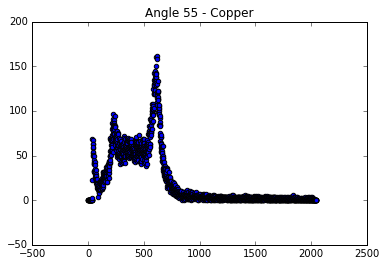

[1.242795993947361, 1.120005097311341]


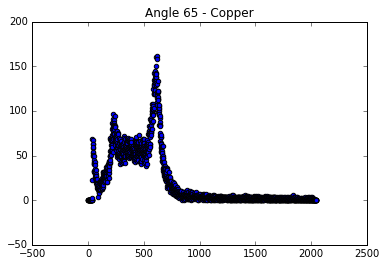

[0.9995213650871105, 1.120005097311341]


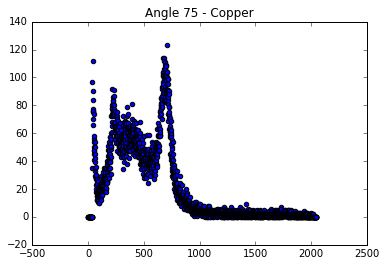

[1.102291597755898, 1.120005097311341]


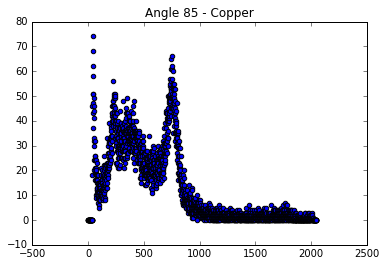

[1.1564759169795706, 1.120005097311341]


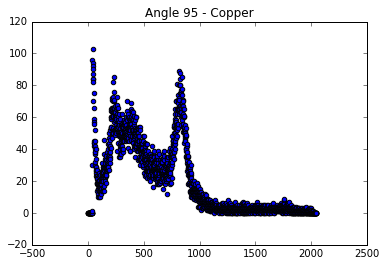

[1.1575192902732165, 1.120005097311341]


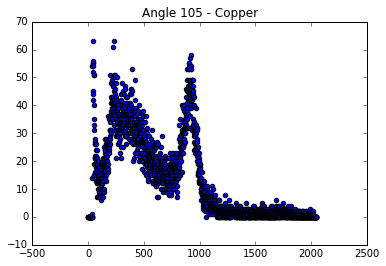

[1.1158584846218227, 1.120005097311341]


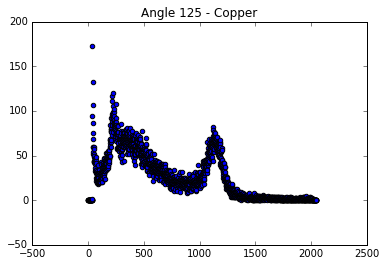

[1.2184893543562536, 1.120005097311341]


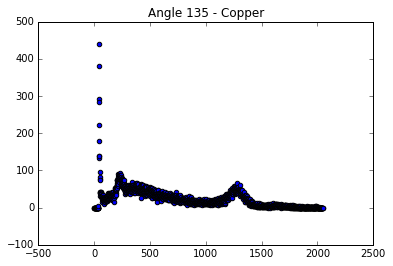

[1.2981365845642352, 1.120005097311341]


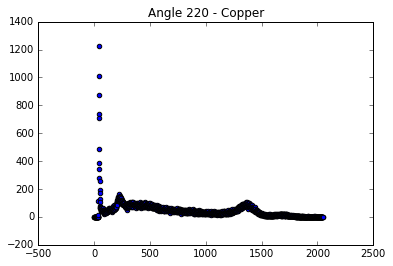

[1.065724586709557, 1.120005097311341]


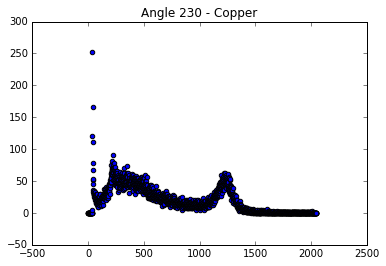

[1.2377052474396488, 1.120005097311341]


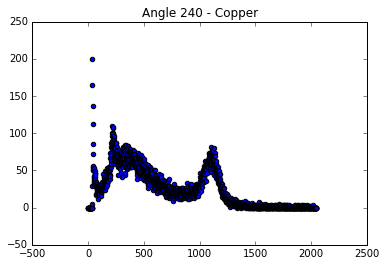

[1.0488114655462275, 1.120005097311341]


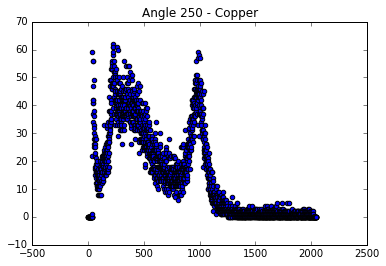

[1.0719926465047367, 1.120005097311341]


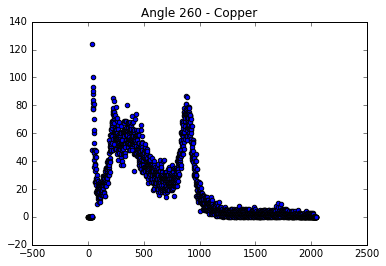

[1.1166875795628828, 1.120005097311341]


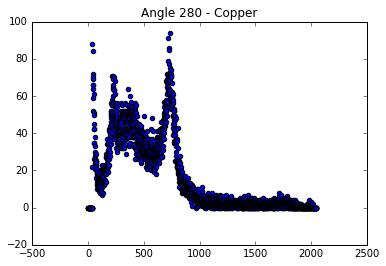

[0.9532672487508612, 1.120005097311341]


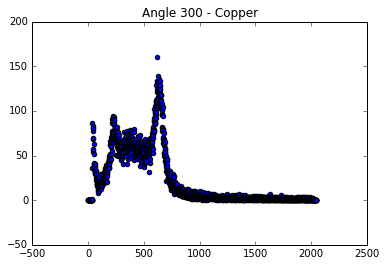

[1.1527062606642917, 1.120005097311341]


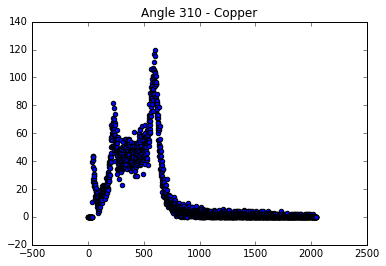

[1.3814518487723537, 1.120005097311341]


In [150]:
###################################################################
###### Copper
### Cu 55
data_Cu1 = mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 004.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 005.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 012.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 013.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 015.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 018.Chn')[1]
data_Cu1 += mphys.data.load_chn('Compton/Angles/55/02 Copper/02 Copper 55 degrees 019.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu1)
plt.title('Angle 55 - Copper')
plt.show()

Cu_55peak_x = 613
Cu_55param = Fit(data_Cu1, 200, Cu_55peak_x)
Cu_55chi = Chi(Cu_55param[0], data_Cu1, 200, Cu_55peak_x)

### Cu 65
data_Cu2 = mphys.data.load_chn('Compton/Angles/65/02 Copper/02 Copper 65 degrees 008.Chn')[1]
data_Cu2 += mphys.data.load_chn('Compton/Angles/65/02 Copper/02 Copper 65 degrees 015.Chn')[1]
data_Cu2 += mphys.data.load_chn('Compton/Angles/65/02 Copper/02 Copper 65 degrees 016.Chn')[1]
data_Cu2 += mphys.data.load_chn('Compton/Angles/65/02 Copper/02 Copper 65 degrees 018.Chn')[1]
data_Cu2 += mphys.data.load_chn('Compton/Angles/65/02 Copper/02 Copper 65 degrees 032.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu1)
plt.title('Angle 65 - Copper')
plt.show()

Cu_65peak_x = 637
Cu_65param = Fit(data_Cu2, 200, Cu_65peak_x)
Cu_65chi = Chi(Cu_65param[0], data_Cu2, 200, Cu_65peak_x)

### Cu 75
data_Cu3 = mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 001.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 002.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 009.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 013.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 024.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 025.Chn')[1]
data_Cu3 += mphys.data.load_chn('Compton/Angles/75/02 Copper/02 Copper 75 degrees 035.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu3)
plt.title('Angle 75 - Copper')
plt.show()

Cu_75peak_x = 685
Cu_75param = Fit(data_Cu3, 200, Cu_75peak_x)
Cu_75chi = Chi(Cu_75param[0], data_Cu3, 200, Cu_75peak_x)

### Cu 85
data_Cu4 = mphys.data.load_chn('Compton/Angles/85/02 Copper/02 Copper 85 degrees 003.Chn')[1]
data_Cu4 += mphys.data.load_chn('Compton/Angles/85/02 Copper/02 Copper 85 degrees 004.Chn')[1]
data_Cu4 += mphys.data.load_chn('Compton/Angles/85/02 Copper/02 Copper 85 degrees 020.Chn')[1]
data_Cu4 += mphys.data.load_chn('Compton/Angles/85/02 Copper/02 Copper 85 degrees 028.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu4)
plt.title('Angle 85 - Copper')
plt.show()

Cu_85peak_x = 752
Cu_85param = Fit(data_Cu4, 200, Cu_85peak_x)
Cu_85chi = Chi(Cu_85param[0], data_Cu4, 200, Cu_85peak_x)

### Cu 95
data_Cu5 = mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 009.Chn')[1]
data_Cu5 += mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 014.Chn')[1]
data_Cu5 += mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 023.Chn')[1]
data_Cu5 += mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 027.Chn')[1]
data_Cu5 += mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 031.Chn')[1]
data_Cu5 += mphys.data.load_chn('Compton/Angles/95/02 Copper/02 Copper 95 degrees 038.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu5)
plt.title('Angle 95 - Copper')
plt.show()

Cu_95peak_x = 825
Cu_95param = Fit(data_Cu5, 200, Cu_95peak_x)
Cu_95chi = Chi(Cu_95param[0], data_Cu5, 200, Cu_95peak_x)

### Cu 105
data_Cu6 = mphys.data.load_chn('Compton/Angles/105/02 Copper/02 Copper 105 degrees 003.Chn')[1]
data_Cu6 += mphys.data.load_chn('Compton/Angles/105/02 Copper/02 Copper 105 degrees 007.Chn')[1]
data_Cu6 += mphys.data.load_chn('Compton/Angles/105/02 Copper/02 Copper 105 degrees 025.Chn')[1]
data_Cu6 += mphys.data.load_chn('Compton/Angles/105/02 Copper/02 Copper 105 degrees 033.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu6)
plt.title('Angle 105 - Copper')
plt.show()

Cu_105peak_x = 903
Cu_105param = Fit(data_Cu6, 200, Cu_105peak_x)
Cu_105chi = Chi(Cu_105param[0], data_Cu6, 200, Cu_105peak_x)

### Cu 125
data_Cu7 = mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 013.Chn')[1]
data_Cu7 += mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 017.Chn')[1]
data_Cu7 += mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 021.Chn')[1]
data_Cu7 += mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 026.Chn')[1]
data_Cu7 += mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 027.Chn')[1]
data_Cu7 += mphys.data.load_chn('Compton/Angles/125/02 Copper/02 Copper 125 degrees 031.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu7)
plt.title('Angle 125 - Copper')
plt.show()

Cu_125peak_x = 1133
Cu_125param = Fit(data_Cu7, 200, Cu_125peak_x)
Cu_125chi = Chi(Cu_125param[0], data_Cu7, 200, Cu_125peak_x)

### Cu 135
data_Cu8 = mphys.data.load_chn('Compton/Angles/135/02 Copper/02 Copper 135 degrees 009.Chn')[1]
data_Cu8 += mphys.data.load_chn('Compton/Angles/135/02 Copper/02 Copper 135 degrees 015.Chn')[1]
data_Cu8 += mphys.data.load_chn('Compton/Angles/135/02 Copper/02 Copper 135 degrees 022.Chn')[1]
data_Cu8 += mphys.data.load_chn('Compton/Angles/135/02 Copper/02 Copper 135 degrees 033.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu8)
plt.title('Angle 135 - Copper')
plt.show()

Cu_135peak_x = 1284
Cu_135param = Fit(data_Cu8, 200, Cu_135peak_x)
Cu_135chi = Chi(Cu_135param[0], data_Cu8, 200, Cu_135peak_x)

### Cu 220
data_Cu9 = mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 010.Chn')[1]
data_Cu9 += mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 011.Chn')[1]
data_Cu9 += mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 020.Chn')[1]
data_Cu9 += mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 028.Chn')[1]
data_Cu9 += mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 030.Chn')[1]
data_Cu9 += mphys.data.load_chn('Compton/Angles/220/02 Copper/02 Copper 220 degrees 036.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu9)
plt.title('Angle 220 - Copper')
plt.show()

Cu_220peak_x = 1363
Cu_220param = Fit(data_Cu9, 200, Cu_220peak_x)
Cu_220chi = Chi(Cu_220param[0], data_Cu9, 200, Cu_220peak_x)

### Cu 230
data_Cu10 = mphys.data.load_chn('Compton/Angles/230/02 Copper/02 Copper 230 degrees 007.Chn')[1]
data_Cu10 += mphys.data.load_chn('Compton/Angles/230/02 Copper/02 Copper 230 degrees 009.Chn')[1]
data_Cu10 += mphys.data.load_chn('Compton/Angles/230/02 Copper/02 Copper 230 degrees 012.Chn')[1]
data_Cu10 += mphys.data.load_chn('Compton/Angles/230/02 Copper/02 Copper 230 degrees 018.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu10)
plt.title('Angle 230 - Copper')
plt.show()

Cu_230peak_x = 1230
Cu_230param = Fit(data_Cu10, 200, Cu_230peak_x)
Cu_230chi = Chi(Cu_230param[0], data_Cu10, 200, Cu_230peak_x)

### Cu 240
data_Cu11 = mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 008.Chn')[1]
data_Cu11 += mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 010.Chn')[1]
data_Cu11 += mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 013.Chn')[1]
data_Cu11 += mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 027.Chn')[1]
data_Cu11 += mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 028.Chn')[1]
data_Cu11 += mphys.data.load_chn('Compton/Angles/240/02 Copper/02 Copper 240 degrees 036.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu11)
plt.title('Angle 240 - Copper')
plt.show()

Cu_240peak_x = 1103
Cu_240param = Fit(data_Cu11, 200, Cu_240peak_x)
Cu_240chi = Chi(Cu_240param[0], data_Cu11, 200, Cu_240peak_x)

### Cu 250
data_Cu12 = mphys.data.load_chn('Compton/Angles/250/02 Copper/02 Copper 250 degrees 004.Chn')[1]
data_Cu12 += mphys.data.load_chn('Compton/Angles/250/02 Copper/02 Copper 250 degrees 010.Chn')[1]
data_Cu12 += mphys.data.load_chn('Compton/Angles/250/02 Copper/02 Copper 250 degrees 021.Chn')[1]
data_Cu12 += mphys.data.load_chn('Compton/Angles/250/02 Copper/02 Copper 250 degrees 032.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu12)
plt.title('Angle 250 - Copper')
plt.show()

Cu_250peak_x = 982
Cu_250param = Fit(data_Cu12, 200, Cu_250peak_x)
Cu_250chi = Chi(Cu_250param[0], data_Cu12, 200, Cu_250peak_x)

### Cu 260
data_Cu13 = mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 000.Chn')[1]
data_Cu13 += mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 009.Chn')[1]
data_Cu13 += mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 011.Chn')[1]
data_Cu13 += mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 021.Chn')[1]
data_Cu13 += mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 031.Chn')[1]
data_Cu13 += mphys.data.load_chn('Compton/Angles/260/02 Copper/02 Copper 260 degrees 036.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu13)
plt.title('Angle 260 - Copper')
plt.show()

Cu_260peak_x = 879
Cu_260param = Fit(data_Cu13, 200, Cu_260peak_x)
Cu_260chi = Chi(Cu_260param[0], data_Cu13, 200, Cu_260peak_x)

### Cu 280
data_Cu14 = mphys.data.load_chn('Compton/Angles/280/02 Copper/02 Copper 280 degrees 016.Chn')[1]
data_Cu14 += mphys.data.load_chn('Compton/Angles/280/02 Copper/02 Copper 280 degrees 020.Chn')[1]
data_Cu14 += mphys.data.load_chn('Compton/Angles/280/02 Copper/02 Copper 280 degrees 027.Chn')[1]
data_Cu14 += mphys.data.load_chn('Compton/Angles/280/02 Copper/02 Copper 280 degrees 032.Chn')[1]
data_Cu14 += mphys.data.load_chn('Compton/Angles/280/02 Copper/02 Copper 280 degrees 038.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu14)
plt.title('Angle 280 - Copper')
plt.show()

Cu_280peak_x = 722
Cu_280param = Fit(data_Cu14, 200, Cu_280peak_x)
Cu_280chi = Chi(Cu_280param[0], data_Cu14, 200, Cu_280peak_x)

### Cu 300
data_Cu15 = mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 003.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 010.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 012.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 017.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 021.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 029.Chn')[1]
data_Cu15 += mphys.data.load_chn('Compton/Angles/300/02 Copper/02 Copper 300 degrees 035.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu15)
plt.title('Angle 300 - Copper')
plt.show()

Cu_300peak_x = 637
Cu_300param = Fit(data_Cu15, 200, Cu_300peak_x)
Cu_300chi = Chi(Cu_300param[0], data_Cu15, 200, Cu_300peak_x)

### Cu 310
data_Cu16 = mphys.data.load_chn('Compton/Angles/310/02 Copper/02 Copper 310 degrees 005.Chn')[1]
data_Cu16 += mphys.data.load_chn('Compton/Angles/310/02 Copper/02 Copper 310 degrees 009.Chn')[1]
data_Cu16 += mphys.data.load_chn('Compton/Angles/310/02 Copper/02 Copper 310 degrees 021.Chn')[1]
data_Cu16 += mphys.data.load_chn('Compton/Angles/310/02 Copper/02 Copper 310 degrees 022.Chn')[1]
data_Cu16 += mphys.data.load_chn('Compton/Angles/310/02 Copper/02 Copper 310 degrees 025.Chn')[1]

plt.scatter(np.arange(0, 2048), data_Cu16)
plt.title('Angle 310 - Copper')
plt.show()

Cu_310peak_x = 583
Cu_310param = Fit(data_Cu16, 200, Cu_310peak_x)
Cu_310chi = Chi(Cu_310param[0], data_Cu16, 200, Cu_310peak_x)

In [151]:
Cu_peaks = np.asarray([Cu_55param[0][0], Cu_65param[0][0], Cu_75param[0][0], Cu_85param[0][0], Cu_95param[0][0], 
                  Cu_105param[0][0], Cu_125param[0][0], Cu_135param[0][0], Cu_220param[0][0], Cu_230param[0][0], Cu_240param[0][0], 
                  Cu_250param[0][0], Cu_260param[0][0], Cu_280param[0][0], Cu_300param[0][0], Cu_310param[0][0]])

Cu_err = np.asarray([Cu_55param[1][0], Cu_65param[1][0], Cu_75param[1][0], Cu_85param[1][0], Cu_95param[1][0], 
                  Cu_105param[1][0], Cu_125param[1][0], Cu_135param[1][0], Cu_220param[1][0], Cu_230param[1][0], Cu_240param[1][0], 
                  Cu_250param[1][0], Cu_260param[1][0], Cu_280param[1][0], Cu_300param[1][0], Cu_310param[1][0]])

Cu_chis = [Cu_55chi, Cu_65chi, Cu_75chi, Cu_85chi, Cu_95chi, Cu_105chi, Cu_125chi, Cu_135chi, Cu_220chi, Cu_230chi, Cu_240chi, 
                  Cu_250chi, Cu_260chi, Cu_280chi, Cu_300chi, Cu_310chi]

for i in np.arange(0, len(Cu_chis)):
    print(Cu_chis[i])
    

[1.242795993947361, 1.120005097311341]
[0.9995213650871105, 1.120005097311341]
[1.102291597755898, 1.120005097311341]
[1.1564759169795706, 1.120005097311341]
[1.1575192902732165, 1.120005097311341]
[1.1158584846218227, 1.120005097311341]
[1.2184893543562536, 1.120005097311341]
[1.2981365845642352, 1.120005097311341]
[1.065724586709557, 1.120005097311341]
[1.2377052474396488, 1.120005097311341]
[1.0488114655462275, 1.120005097311341]
[1.0719926465047367, 1.120005097311341]
[1.1166875795628828, 1.120005097311341]
[0.9532672487508612, 1.120005097311341]
[1.1527062606642917, 1.120005097311341]
[1.3814518487723537, 1.120005097311341]


[503.62091172   0.84212547]
[1.40890443 0.11494856]
292.0139161586664


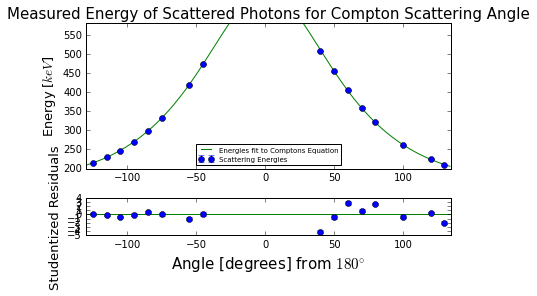

In [153]:
Cu_angles = np.asarray([55, 65, 75, 85, 95, 105, 125, 135, 220, 230, 240, 250, 260, 280, 300, 310])-180

Cu_energies = Linear(Cu_peaks, *linearFit_par)

Cu_energies_err = linearFit_par[0]*np.asarray(Cu_err)

Cu_cov, Cu_pov = curve_fit(Energy, Cu_angles, Cu_energies, p0=[510, 0.1])

Cu_residuals = (Cu_energies-Energy(Cu_angles, *Cu_cov))

pltCu, axCu = plt.subplots(2, 1, sharey='row', tight_layout = True, gridspec_kw={'height_ratios':[4,1]})

axCu[0].errorbar(Cu_angles, Cu_energies, yerr=Cu_energies_err, fmt='o', label='Scattering Energies')
axCu[0].plot(np.arange(-130, 135), Energy(np.arange(-130, 135), *Cu_cov), label = 'Energies fit to Comptons Equation')
axCu[0].set_ylim(top = 580)

axCu[0].set_xlim(-130, 135)
axCu[1].set_xlim(-130, 135)

axCu[1].errorbar(Cu_angles, Cu_residuals, yerr=Cu_energies_err, fmt='o')
axCu[1].plot(np.arange(-130, 135), np.zeros(265))

axCu[1].set_xlabel('Angle [degrees] from $180^{\circ}$', fontsize=15)
axCu[1].set_ylabel('Studentized Residuals', fontsize=13)
axCu[0].set_ylabel('Energy [$keV$]', fontsize=13)
axCu[0].legend(loc='lower center', prop={'size':7})
axCu[0].set_title('Measured Energy of Scattered Photons for Compton Scattering Angle', fontsize=15)

pltCu.savefig('Plots/Cu_Compton.svg')

print(Cu_cov), print(np.sqrt(np.diag(Cu_pov)))
print(Chi2(Cu_angles, Cu_cov, Cu_energies, Cu_energies_err))